✅ Dataset downloaded!
✅ Data loaded!
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_diff_srv_rate  \
0               0       0    0  ...                    0.03   
1               0       0    0  ...                    0.60   
2               0       0    0  ...                    0.05   
3               0       0    0  ...                    0.00   
4               0       0    0  ...                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                        

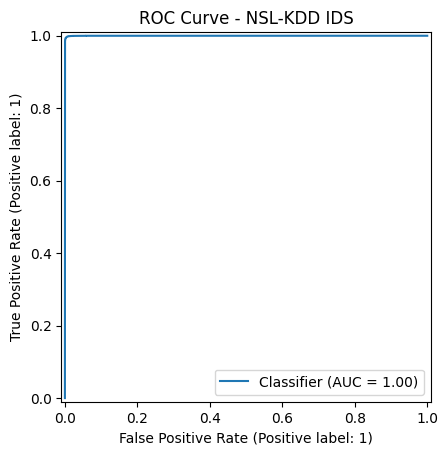


5-Fold F1 Score: 0.9957634204748175 +/- 0.00034211389207151736
✅ Model saved at artifacts/nslkdd_rf_pipeline.joblib


In [1]:
# =========================================
# 📌 Intrusion Detection System (IDS) with ML
# Dataset: NSL-KDD
# Platform: Google Colab
# Author: Your Name
# =========================================

# STEP 1: Install dependencies
!pip install -U pandas numpy scikit-learn imbalanced-learn xgboost matplotlib seaborn joblib

# STEP 2: Import libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib
import urllib.request
import zipfile
import os

# STEP 3: Download NSL-KDD dataset from GitHub
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
train_file = "KDDTrain+.txt"
urllib.request.urlretrieve(url, train_file)

url_test = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt"
test_file = "KDDTest+.txt"
urllib.request.urlretrieve(url_test, test_file)

print("✅ Dataset downloaded!")

# STEP 4: Define column names
cols = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
    'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty'
]

# STEP 5: Load datasets
train_df = pd.read_csv(train_file, names=cols)
test_df  = pd.read_csv(test_file, names=cols)

# Binary label (normal=0, attack=1)
train_df['binary_label'] = (train_df['label'] != 'normal').astype(int)
test_df['binary_label'] = (test_df['label'] != 'normal').astype(int)

df = pd.concat([train_df, test_df], ignore_index=True)

print("✅ Data loaded!")
print(df.head())

# STEP 6: Feature / Label split
y = df['binary_label']
X = df.drop(columns=['label','difficulty','binary_label'])

cat = ['protocol_type','service','flag']
num = [c for c in X.columns if c not in cat]

# STEP 7: Preprocessing + Pipeline
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat),
    ("num", StandardScaler(with_mean=False), num),
])

clf = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)

pipe = Pipeline(steps=[
    ("pre", pre),
    ("smote", SMOTE(random_state=42)),
    ("clf", clf)
])

# STEP 8: Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# STEP 9: Train
pipe.fit(X_train, y_train)

# STEP 10: Evaluate
preds = pipe.predict(X_val)
proba = pipe.predict_proba(X_val)[:,1]

print("\n=== Classification Report ===")
print(classification_report(y_val, preds, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, preds))
print("ROC-AUC:", roc_auc_score(y_val, proba))

# ROC Curve
RocCurveDisplay.from_predictions(y_val, proba)
plt.title("ROC Curve - NSL-KDD IDS")
plt.show()

# STEP 11: Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")
print("\n5-Fold F1 Score:", scores.mean(), "+/-", scores.std())

# STEP 12: Save trained model
os.makedirs("artifacts", exist_ok=True)
joblib.dump(pipe, "artifacts/nslkdd_rf_pipeline.joblib")
print("✅ Model saved at artifacts/nslkdd_rf_pipeline.joblib")
